In [37]:
# Setup
!pip install --quiet --upgrade pip

# Install the dependencies.
!pip install --quiet -r requirements_tf.txt

# Restart the runtime by ending the process.
exit()

In [1]:
import os
import matplotlib.pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0 = all messages, 1 = INFO, 2 = WARNING, 3 = ERROR
import numpy as np
import pandas as pd
import tensorflow as tf
from google.cloud import storage
import google.auth
from importlib import reload
from serving.constants import  BUCKET, IMG_SOURCE_PREFIX, HIST_DEST_PREFIX, HIST_BINS_LIST, SCALE, CROP, MONTHS, IMAGE_BATCH, NUM_BINS, MAP_NAN, NORMALIZE
from serving.common import list_blobs_with_prefix
from serving.hist_training import create_hist_dataset, create_data_sample, get_labels, LstmModel, TimeDependentDenseLstmModel #, load_dataset_from_gcp, save_dataset_to_gcp
from serving.data import check_blob_prefix_exists, batch_check_blobs, get_varied_labels, check_blob_exists
import logging
import io
import itertools
import time

from keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop

from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import mlflow
import mlflow.keras
import matplotlib.pyplot as plt

In [16]:
# SETUP

#####
CREATE_DATASET = True
#####

start_time = time.perf_counter()
credentials, _ = google.auth.default()
bucket_name = BUCKET
directory_prefix = IMG_SOURCE_PREFIX
output_prefix = HIST_DEST_PREFIX
labels_data = "labels_combined.npy"
labels_header = "labels_header.npy"
batch_size = 1
months = MONTHS
map_nan = MAP_NAN
normalize = NORMALIZE

client = storage.Client()
bucket = client.get_bucket(bucket_name)
num_bins = NUM_BINS
img_range = [1,10]

In [17]:
batch_size

1

In [3]:
def save_dataset_to_gcp(
    dataset, bucket_name="vgnn", file_name="hist_dataset_medium.tfrecords", directory="dataset"
):
    # Initialize GCP client
    client = storage.Client()
    bucket = client.bucket(bucket_name)

    # Create a local temporary file
    local_file_name = "temp_" + file_name

    # Write the dataset to the local file
    with tf.io.TFRecordWriter(local_file_name) as writer:
        for features, label in dataset:
            example = serialize_example(features, label)
            writer.write(example)

        # Upload to GCS
        full_name = "/".join([directory,file_name])
        blob = bucket.blob(f"{full_name}")
        blob.upload_from_filename(local_file_name)

    print(f"Dataset saved to gs://{bucket_name}/{full_name}")
    
def parse_tfrecord_fn(example_proto):
    # Define the features dictionary that matches the structure used when saving
    feature_description = {
        "feature": tf.io.FixedLenFeature([], tf.string),
        "label": tf.io.FixedLenFeature([], tf.float32),
    }

    # Parse the input tf.Example proto using the feature description
    parsed_features = tf.io.parse_single_example(example_proto, feature_description)

    # Decode the feature from the parsed example
    feature = tf.io.parse_tensor(parsed_features["feature"], out_type=tf.float32)
    label = parsed_features["label"]
    return feature, label


def load_dataset_from_gcp(
    bucket_name="vgnn", file_name="dataset.tfrecords", directory="dataset"
):
    # Construct the full GCS path
    full_file_name = "/".join([directory,file_name])
    gcs_path = f"gs://{bucket_name}/{full_file_name}"
    print(f"path: {gcs_path}")
    # Create a TFRecordDataset
    dataset = tf.data.TFRecordDataset(gcs_path)

    # Parse the TFRecords
    parsed_dataset = dataset.map(parse_tfrecord_fn)

    return parsed_dataset

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()  # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))


def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def serialize_example(features, label):
    """
    Creates a tf.train.Example message ready to be written to a file.
    """
    # Create a dictionary mapping the feature name to the tf.train.Example-compatible
    # data type.
    feature = {
        "feature": _bytes_feature(tf.io.serialize_tensor(features)),
        "label": _float_feature(label),
    }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

In [4]:
directory = f"dataset/nan_map_{map_nan}/norm_{normalize}/{num_bins}_buckets/{SCALE}"
file_name =  "dataset.tfrecords" # "hist_dataset_medium" # 


if CREATE_DATASET:
    # Generate all prefixes
    start_time = time.perf_counter()
    
    labels_df = get_varied_labels(*img_range)
    labels = list(zip(labels_df["county_name"],
                      labels_df["county_ansi"],
                 labels_df["state_ansi"],
                 labels_df["year"]))


    prefixes_hist = [f'histograms/nan_map_{map_nan}/norm_{normalize}/{num_bins}_buckets_{len(HIST_BINS_LIST)}_bands/{SCALE}/{county.capitalize()}_{fips}/{year}' 
                for county,_, fips, year in labels
                    for month in months]

    # Batch check all prefixes
    results_hist = batch_check_blobs(bucket_name, prefixes_hist)

    # Generate get_input_img_params based on results
    get_input_img_params = [(county.capitalize(), fips, year)
                for county, county_fips, fips, year in labels
                if results_hist[f'histograms/nan_map_{map_nan}/norm_{normalize}/{num_bins}_buckets_{len(HIST_BINS_LIST)}_bands/{SCALE}/{county.capitalize()}_{fips}/{year}']
    ]

    print(f"Number of items to process: {len(get_input_img_params)}")
    
    end_time_dataset_info = time.perf_counter()
    print(f"Collecting dataset information: {end_time_dataset_info-start_time}")
    
    dataset, input_shape = create_hist_dataset(get_input_img_params, "labels_combined.npy", "labels_header.npy", num_bins=num_bins)
    end_time_dataset = time.perf_counter()
    
    print(f"Building dataset: {(end_time_dataset - end_time_dataset_info)/60:.02} minutes")
    
    # Save dataset
    save_dataset_to_gcp(dataset, file_name = file_name, directory=directory)
    print("Dataset created")
    CREATE_DATASET = False
else:
    
    dataset = load_dataset_from_gcp(file_name=file_name, directory=directory)
    for features, label in dataset.take(1):
        input_shape = tuple(features.shape)
        label_shape = label.shape
    print("Dataset loaded")

Number of items to process: 54
Reshaped histograms shape: (54, 3, 288)
Labels shape: (54, 1)
Number of filtered combinations: 0
Number of missing histograms replaced by zeros: 0
Building dataset: 0.34 minutes
Dataset saved to gs://vgnn/dataset/nan_map_True/norm_True/32_buckets/60/dataset.tfrecords
Dataset created


In [14]:
if not tf.executing_eagerly():
    print("switching")
    tf.config.run_functions_eagerly(True)

In [ ]:
import tensorflow as tf

# tf.data.experimental.enable_debug_mode()

loaded_dataset = load_dataset_from_gcp(file_name=file_name, directory=directory)
for features, label in loaded_dataset.take(2):
    print("Loaded Features:", features.numpy(), "Loaded Label:", label.numpy())

In [20]:
batch_size

1

In [19]:
# Create training and testing datasets
train_size = 50
dataset_shuffled = dataset.shuffle(buffer_size=10000).batch(batch_size)
test_dataset = dataset_shuffled.skip(train_size)
train_dataset = dataset_shuffled.take(train_size)

In [6]:
# Sample labels
label_data = np.load(labels_data, allow_pickle=True)
label_header = np.load(labels_header, allow_pickle=True)
label_df = pd.DataFrame(label_data, columns=label_header)
label_df[label_df["county_name"]=='Sutter'.upper()]

,commodity_desc,reference_period_desc,year,state_ansi,state_name,county_ansi,county_name,target,source_file
66,CORN,YEAR,2016,06,CALIFORNIA,101,SUTTER,264.1,USDA_Corn_County_2016.csv
3045,CORN,YEAR,2018,06,CALIFORNIA,101,SUTTER,210.0,USDA_Corn_County_2018.csv
4389,CORN,YEAR,2019,06,CALIFORNIA,101,SUTTER,147.1,USDA_Corn_County_2019.csv
7314,CORN,YEAR,2021,06,CALIFORNIA,101,SUTTER,169.9,USDA_Corn_County_2021.csv
8791,CORN,YEAR,2022,06,CALIFORNIA,101,SUTTER,133.8,USDA_Corn_County_2022.csv


In [23]:
model = TimeDependentDenseLstmModel(input_shape=input_shape, lstm_layers=0, dense_layers_per_step=10, no_units=0, val_size=2)
model.compile(optimizer='nadam', learning_rate = 0.001)
history = model.fit(train_dataset, epochs=20)

Epoch 1/20
48/48 [==============================] - 10s 199ms/step - loss: 34755.0273 - mae: 130.1503 - val_loss: 42791.1484 - val_mae: 199.5194
Epoch 2/20
48/48 [==============================] - 11s 225ms/step - loss: 13399.4795 - mae: 102.9164 - val_loss: 12281.5439 - val_mae: 89.0815
Epoch 3/20
48/48 [==============================] - 9s 188ms/step - loss: 24673.0996 - mae: 128.6183 - val_loss: 29916.1289 - val_mae: 171.2042
Epoch 4/20
40/48 [========================>.....] - ETA: 1s - loss: 18935.9727 - mae: 117.7992

KeyboardInterrupt: 

In [ ]:
responses = []
features = []
for feature, response in dataset:
    print(feature.shape)
    print(feature.numpy().reshape(-1).sum())
    print(response)
    features.append(feature.numpy())
    responses.append(response.numpy())
mean_response = np.mean(responses)
print(mean_response)



In [13]:
len(features)

54

In [23]:
input_shape

(3, 96)

In [25]:
model = LstmModel(input_shape=input_shape, lstm_layers=4, no_units=2)
model.compile(optimizer='nadam', learning_rate = 0.5)
history = model.fit(test_dataset, epochs=25)

ValueError: need at least one array to concatenate

In [13]:
responses

[]

In [8]:
print(model.naive_loss)
print(model.job_name)

184.98001
jovial-soda


In [ ]:
for layer in model.layers:
    # Get weights for the layer
    weights = layer.get_weights()
    
    # Check if the layer has weights
    if weights:
        print(f"Layer: {layer.name}")
        for i, weight in enumerate(weights):
            print(f"  Weight {i+1} shape: {weight.shape}")
            print(f"  Weight {i+1} values: \n{weight}\n")
    else:
        print(f"Layer: {layer.name} has no weights.")

In [18]:
test_dataset

<_SkipDataset element_spec=(TensorSpec(shape=(None, 3, 96), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

In [17]:
predictions = model.predict(test_dataset)

4/4 [==============================] - 0s 31ms/step


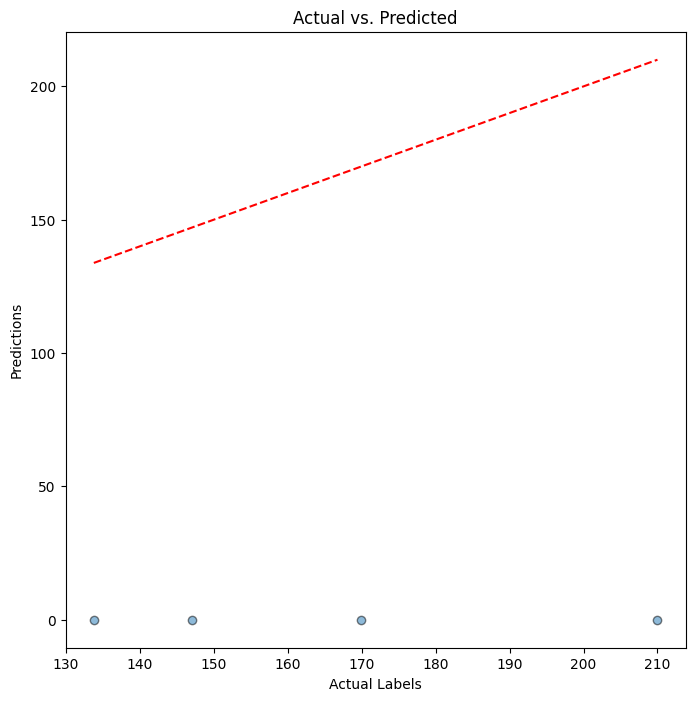

In [19]:
actual_labels = np.concatenate([response.numpy() for _, response in test_dataset], axis=0)

# Plot actual vs. predicted
plt.figure(figsize=(8, 8))
plt.scatter(actual_labels, predictions, alpha=0.5, edgecolors='k')
plt.xlabel('Actual Labels')
plt.ylabel('Predictions')
plt.title('Actual vs. Predicted')
plt.plot([min(actual_labels), max(actual_labels)], [min(actual_labels), max(actual_labels)], 'r--')  # Line y=x for reference
plt.show()